In [6]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import plotly.express as px
from plotly import graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

pd.set_option('display.max_columns', None)

In [77]:
import warnings
warnings.filterwarnings("ignore")

# Подключаемся к базе данных

In [15]:
db_config = {
    'user': 'student', 
    'pwd': 'JvLda93aA', 
    'host': '158.160.52.106',
    'port': 5432, 
    'db': 'postgres'
} 
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
 db_config['pwd'],
 db_config['host'],
 db_config['port'],
 db_config['db'])

engine = create_engine(connection_string) 

In [16]:
from sqlalchemy import create_engine, text as sql_text

In [19]:
def select(sql):
    return pd.read_sql_query(con=engine.connect(), sql=sql_text(sql))

In [38]:
sql = '''
select
  visit_dttm,
  client_rk,
  account_rk,
  application_rk,
  game_rk,
  game_flg
from
  (
    select
      client_rk,
      visit_dttm
    from
      msu_analytics.client
  ) as client
  left join (
    select
      account_rk,
      client_rk,
      registration_dttm
    from
      msu_analytics.account a
  ) as account using(client_rk)
  left join (
    select
      application_rk,
      account_rk,
      game_rk,
      application_dttm
    from
      msu_analytics.application a
  ) as application using(account_rk)
  left join (
    select
      game_rk,
      game_dttm,
      game_flg
    from
      msu_analytics.game
  ) as game using(game_rk)
'''

df = select(sql)

In [39]:
print('начало:', df['visit_dttm'].min())
print('конец:', df['visit_dttm'].max())

начало: 2022-09-01 03:32:43.977277
конец: 2023-02-02 02:22:04.176738


In [40]:
df = df.set_index("visit_dttm")

In [41]:
df.head()

,client_rk,account_rk,application_rk,game_rk,game_flg
visit_dttm,,,,,
2022-12-19 13:39:26.805938,418,924.0,NaN,NaN,NaN
2023-01-12 13:45:14.412743,2651,1004.0,NaN,NaN,NaN
2022-11-09 15:18:10.742826,2667,193.0,NaN,NaN,NaN
2022-10-09 12:23:32.525672,2976,567.0,NaN,NaN,NaN
2022-12-14 16:57:43.565549,3040,241.0,NaN,NaN,NaN


# Воронка за весь период

In [48]:
funnel = (
    df.resample(rule="M").agg(
        {
            "client_rk": "nunique",
            "account_rk": "nunique",
            "application_rk": "nunique",
            "game_flg": "sum",
        }).reset_index().rename(
        columns={
            "client_rk": "Посещения",
            "account_rk": "Регистрации",
            "application_rk": "Заявки",
            "game_flg": "Игры",
        }))

In [49]:
general_funnel = pd.melt(
    funnel,
    id_vars=["visit_dttm"],
    value_vars=["Посещения", "Регистрации", "Заявки", "Игры"],
    var_name="stage",
    value_name="value",
).groupby("stage", as_index=False).agg({"value": "sum"}).sort_values("value", ascending=False)

In [57]:
fig = go.Figure(
    go.Funnel(
        y=general_funnel.stage,
        x=general_funnel.value,
        textposition="inside",
        marker={"color": ["lightblue", "lightgreen", "pink", "orange"]},
        textinfo="value+percent previous",
    )
)

fig.show()

# Воронка по месяцам

In [62]:
month_funnel = (
    df.resample(rule="MS").agg(
        {
            "client_rk": "nunique",
            "account_rk": "nunique",
            "application_rk": "nunique",
            "game_flg": "sum",
        }).reset_index())

In [63]:
month_funnel = month_funnel.sort_values("visit_dttm", ascending=False)
month_funnel["month_name"] = month_funnel.visit_dttm.dt.month_name()
month_funnel.game_flg = month_funnel.game_flg.astype("int")
month_funnel = month_funnel.query('month_name != "February"')
month_funnel["cr_client_rk"] = month_funnel.client_rk.apply(lambda x: str(x) + " " + "(100%)")

In [64]:
month_funnel["cr_account_rk"] = (
    month_funnel.account_rk.astype("str") + " (" + round(month_funnel["account_rk"] / month_funnel["client_rk"] * 100, 2).astype("str") + "%)")

month_funnel["cr_application_rk"] = (
    month_funnel.application_rk.astype("str") + " (" + round(month_funnel["application_rk"] / month_funnel["account_rk"] * 100, 2).astype("str") + "%)")
    
month_funnel["cr_game_flg"] = (
    month_funnel.game_flg.astype("str")+ " (" + round(month_funnel["game_flg"] / month_funnel["application_rk"] * 100, 2).astype("str") + "%)")

In [67]:
years = month_funnel.month_name
fig = go.Figure()
fig.add_trace(go.Bar(
        x=month_funnel.game_flg,
        y=years,
        name="Игры",
        marker_color="orange",
        orientation="h",
        text=month_funnel.cr_game_flg,
        textposition="outside",
    ))

fig.add_trace(
    go.Bar(
        x=month_funnel.application_rk,
        y=years,
        name="Заявки",
        marker_color="pink",
        orientation="h",
        text=month_funnel.cr_application_rk,
        textposition="outside",
    ))

fig.add_trace(
    go.Bar(
        x=month_funnel.account_rk,
        y=years,
        name="Регистрации",
        marker_color="lightgreen",
        orientation="h",
        text=month_funnel.cr_account_rk,
        textposition="outside",
    ))

fig.add_trace(
    go.Bar(
        x=month_funnel.client_rk,
        y=years,
        name="Посещения",
        marker_color="lightblue",
        orientation="h",
        text=month_funnel.cr_client_rk,
        textposition="inside",
    ))

# Воронка по неделям

In [75]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [69]:
sql = '''SELECT DATE_TRUNC('week', visit_dttm) AS week_start, 
            COUNT(DISTINCT c.client_rk) AS num_visitors,
            COUNT(DISTINCT a.account_rk) AS num_registrations, 
            COUNT(DISTINCT ap.account_rk) AS num_applications, 
            sum(case when g.finish_flg = 1 then 1 else 0 end) AS num_games 
            FROM msu_analytics.client c 
            LEFT JOIN msu_analytics.account a ON c.client_rk = a.client_rk 
            LEFT JOIN msu_analytics.application ap ON a.account_rk = ap.account_rk 
            LEFT JOIN msu_analytics.game g ON g.game_rk = ap.game_rk 
            GROUP BY week_start 
            ORDER BY week_start'''
df2 = select(sql)

In [71]:
df2.head()

,week_start,num_visitors,num_registrations,num_applications,num_games
0,2022-08-29,111,32,7,3
1,2022-09-05,184,31,6,2
2,2022-09-12,167,43,16,5
3,2022-09-19,181,45,12,12
4,2022-09-26,195,59,17,10


In [73]:
registrations_percent = df2['num_registrations'] / df2['num_visitors'] * 100
applications_percent = df2['num_applications'] / df2['num_visitors'] * 100
games_percent = df2['num_games'] / df2['num_visitors'] * 100

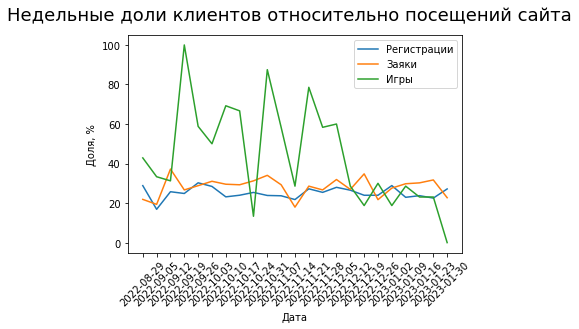

In [84]:
fig, ax = plt.subplots()
dates = df2['week_start'].astype(str)
ax.plot(dates, registrations_percent, label='Регистрации')
ax.plot(dates, applications_percent, label='Заяки')
ax.plot(dates, games_percent, label='Игры')
ax.legend()
fig.suptitle('Недельные доли клиентов относительно посещений сайта', fontsize=18)
plt.ylabel('Доля, %')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()

In [83]:
registrations_percent = df2['num_registrations'] / df2['num_visitors'] * 100
applications_percent = df2['num_applications'] / df2['num_registrations'] * 100
games_percent = df2['num_games'] / df2['num_applications'] * 100

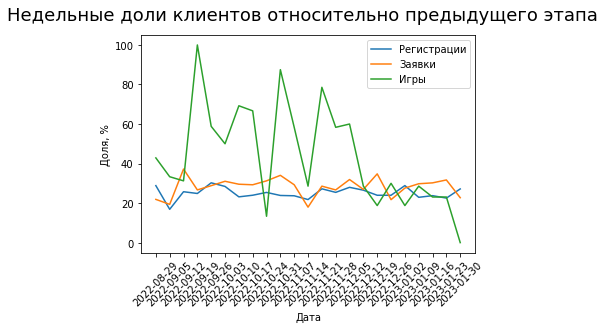

In [86]:
fig, ax = plt.subplots()
dates = df2['week_start'].astype(str)
ax.plot(dates, registrations_percent, label='Регистрации')
ax.plot(dates, applications_percent, label='Заявки')
ax.plot(dates, games_percent, label='Игры')
ax.legend()
fig.suptitle('Недельные доли клиентов относительно предыдущего этапа', fontsize=18)
plt.ylabel('Доля, %')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()

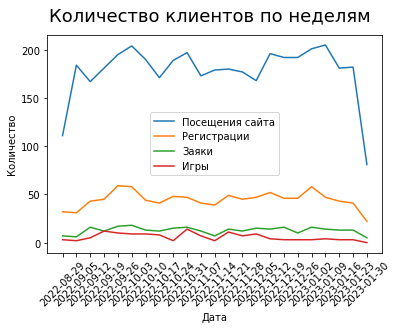

In [88]:
fig, ax = plt.subplots()
dates = df2['week_start'].astype(str)
ax.plot(dates, df2['num_visitors'], label='Посещения сайта')
ax.plot(dates, df2['num_registrations'], label='Регистрации')
ax.plot(dates, df2['num_applications'], label='Заяки')
ax.plot(dates, df2['num_games'], label='Игры')
ax.legend()
fig.suptitle('Количество клиентов по неделям', fontsize=18)
plt.ylabel('Количество')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()

# Выводы

**Из проведенного исследования можно сделать выводы, необходимые для улучшения эффективности работы сайта и повышения его привлекательности для клиентов:**

- Наибольшее количество клиентов теряется на этапе посещения сайта. Только 25% посетителей регистрируют аккаунт. Для решения этой проблемы необходимо упростить процесс регистрации, сделать его максимально быстрым и простым, а также стимулировать клиентов к его заведению. 

- Только 50% зарегистрированных клиентов подают заявки на игры. Для решения этой проблемы необходимо также упростить и ускорить процесс подачи заявки на игру. Может быть, стоит дополнительно обзванивать зарегистрированных пользователей, или добавить пуши.

- Наибольшее число пройденных игр было зарегистрировано на неделях, когда приток новых клиентов был максимальным. В течение предновогодних недель приток посетителей сохранялся на прежнем уровне, однако люди не проявляли интерес к играм. Новогодние праздники значительно снизили общую конверсию. 

- Заметно значительное падение конверсии, начиная с 50-й недели, и снижение конверсии до 0 на 5-й неделе 2023 года. Максимальная конверсия была зарегистрирована в 38, 44 и 47 недели. 

- Месяцы сохраняют схожий уровень посещения сайта и структуру воронок. 

- Посещение сайта новыми клиентами сохраняется на прежнем уровне. Однако месячная конверсия снизилась в декабре и январе.

**Исходя из сделанных выводов, можно выделить несколько точек роста продукта:**

- Упрощение и ускорение процессов регистрации и подачи заявки на игру. Это должно увеличить конверсию и привести к увеличению числа клиентов, которые оставляют заявки или регистрируют аккаунты.

- Необходимо стимулировать клиентов регистрировать аккаунты. Для достижения этой цели можно предложить бонусы за регистрацию каких-то услуг.

- Следует учитывать особенности новогодних праздников и сохранять маркетинговую активность в этот период. Необходимо разработать новогодние акции, мероприятия и предложения для клиентов, чтобы привлечь их в это время.

- Рекомендуется проанализировать причины значительного падения конверсии, начиная с 50-й недели, и предпринять меры по ее повышению, например, с помощью проведения дополнительных маркетинговых мероприятий